# Volume Forecasting Performance Analyst Exercise

### Import Libraries

In [50]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Statistical Analysis
import scipy.stats as stats
from statsmodels.tsa.stattools import grangercausalitytests

# Working with Dates & Time
import datetime
import time

# Setting up visualization style
sns.set_style("whitegrid")
plt.style.use("seaborn")

print("All libraries imported successfully!")


All libraries imported successfully!


C:\Users\patri\AppData\Local\Temp\ipykernel_36888\1692755056.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


### Data Loading and Exploration

In [23]:
# Load dataset
vf_perf_df = pd.read_csv('vf_performance_analyst_exercise_data.csv')

# Display basic info
print(vf_perf_df.info())
print(vf_perf_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DATE                              17520 non-null  object 
 1   HH                                17520 non-null  int64  
 2   WIND_SPEED_MS                     17520 non-null  float64
 3   GENERATION_MW                     17520 non-null  float64
 4   SEASONAL_NORMAL_WIND_SPEED_KNOTS  17520 non-null  float64
 5   CASHOUT_PRICE_GBP_PER_MWH         17520 non-null  float64
 6   FORWARD_PRICE_GBP_PER_MWH         17520 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 958.3+ KB
None
         DATE  HH  WIND_SPEED_MS  GENERATION_MW  \
0  01/01/2022   1           10.2          4.564   
1  01/01/2022   2           11.2          3.870   
2  01/01/2022   3           13.2          7.456   
3  01/01/2022   4           13.3          8.910   
4

### Dealing with Date and time

In [93]:
# Convert DATE column to datetime format
vf_perf_df["DATE"] = pd.to_datetime(vf_perf_df["DATE"], dayfirst=True)
print("DATE column successfully converted!")

# Ensure the HH column is of integer type (if it isn't already)
vf_perf_df['HH'] = vf_perf_df['HH'].astype(int)

# Choose a base date. Here, we assume the data is for January 1, 2022.
base_date = pd.Timestamp("01/01/2022")

# Create a new column 'timestamp' by adding (HH-1)*30 minutes to the base date.
# Note: HH=1 corresponds to 00:00-00:30, so we start at 00:00.
vf_perf_df['TIMESTAMP'] = vf_perf_df['HH'].apply(lambda x: base_date + pd.Timedelta(minutes=(x-1)*30))

# Optionally, set the 'timestamp' column as the DataFrame index
vf_perf_df.set_index('TIMESTAMP', inplace=True)

# Preview the prepared DataFrame
print(vf_perf_df.head())


DATE column successfully converted!
                          DATE  HH  WIND_SPEED_MS  GENERATION_MW  \
TIMESTAMP                                                          
2022-01-01 00:00:00 2022-01-01   1           10.2          4.564   
2022-01-01 00:30:00 2022-01-01   2           11.2          3.870   
2022-01-01 01:00:00 2022-01-01   3           13.2          7.456   
2022-01-01 01:30:00 2022-01-01   4           13.3          8.910   
2022-01-01 02:00:00 2022-01-01   5           13.4          9.254   

                     SEASONAL_NORMAL_WIND_SPEED_KNOTS  \
TIMESTAMP                                               
2022-01-01 00:00:00                               9.6   
2022-01-01 00:30:00                               9.3   
2022-01-01 01:00:00                               9.3   
2022-01-01 01:30:00                               9.2   
2022-01-01 02:00:00                               9.2   

                     CASHOUT_PRICE_GBP_PER_MWH  FORWARD_PRICE_GBP_PER_MWH  \
TIMESTAMP 

### Check for Missing values and Summary Statistics

In [94]:
# Check for missing values
print("Missing Values:")
print(vf_perf_df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(vf_perf_df.describe())



Missing Values:
DATE                                0
HH                                  0
WIND_SPEED_MS                       0
GENERATION_MW                       0
SEASONAL_NORMAL_WIND_SPEED_KNOTS    0
CASHOUT_PRICE_GBP_PER_MWH           0
FORWARD_PRICE_GBP_PER_MWH           0
GENERATION_PREDICTED                0
FORECAST_ERROR                      0
P&L_IMPACT                          0
Forecast_Error                      0
PnL                                 0
dtype: int64

Summary Statistics:
                 HH  WIND_SPEED_MS  GENERATION_MW  \
count  17520.000000   17520.000000   17520.000000   
mean      24.500000       9.075485       2.633981   
std       13.853794       3.970261       2.713943   
min        1.000000      -6.000000      -3.000000   
25%       12.750000       6.200000       0.428000   
50%       24.500000       8.800000       1.634000   
75%       36.250000      11.700000       4.136000   
max       48.000000      80.200000      20.000000   

       SEASONAL

### Exploratory Visuals

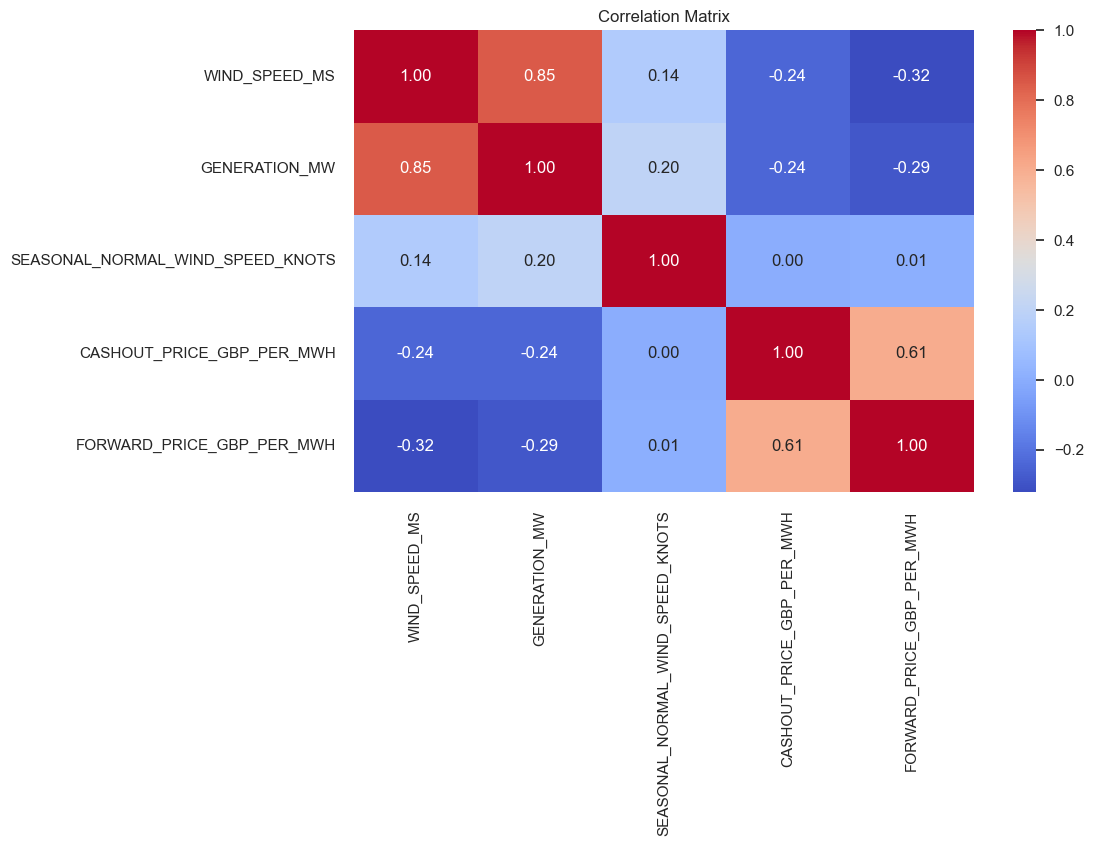

In [101]:
# Correlation matrix

# Select all numerical fields into one variable
numeric_data = vf_perf_df[["WIND_SPEED_MS", "GENERATION_MW", "SEASONAL_NORMAL_WIND_SPEED_KNOTS", 
                            "CASHOUT_PRICE_GBP_PER_MWH", "FORWARD_PRICE_GBP_PER_MWH"]]


# Plot Corr matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


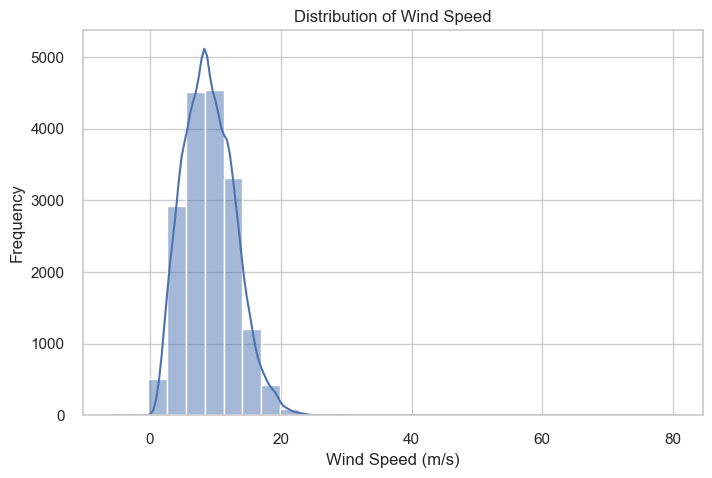

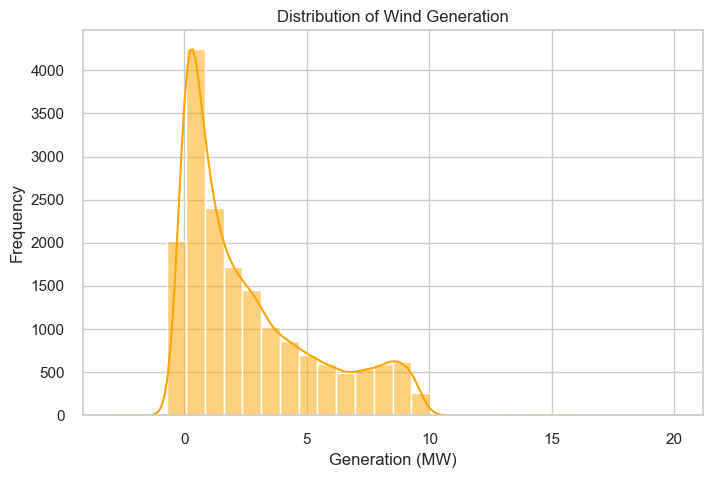

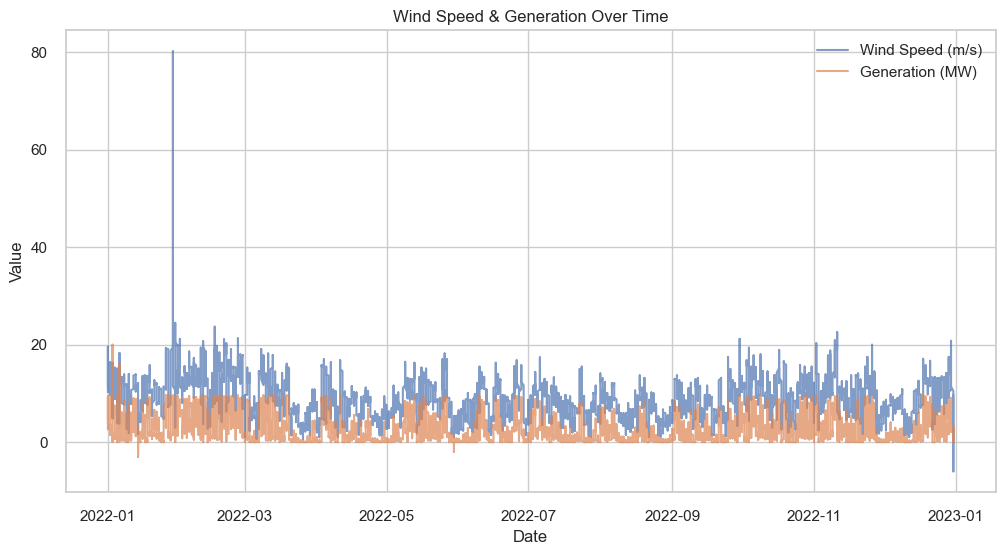

In [102]:
# Distribution of Wind Speed
plt.figure(figsize=(8, 5))
sns.histplot(vf_perf_df["WIND_SPEED_MS"], bins=30, kde=True)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Distribution of Wind Speed")
plt.grid(True)
plt.show()

# Distribution of Generation
plt.figure(figsize=(8, 5))
sns.histplot(vf_perf_df["GENERATION_MW"], bins=30, kde=True, color='orange')
plt.xlabel("Generation (MW)")
plt.ylabel("Frequency")
plt.title("Distribution of Wind Generation")
plt.grid(True)
plt.show()

# Time series trend of wind speed and generation
plt.figure(figsize=(12, 6))
plt.plot(vf_perf_df["DATE"], vf_perf_df["WIND_SPEED_MS"], label="Wind Speed (m/s)", alpha=0.7)
plt.plot(vf_perf_df["DATE"], vf_perf_df["GENERATION_MW"], label="Generation (MW)", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Wind Speed & Generation Over Time")
plt.legend()
plt.grid(True)
plt.show()

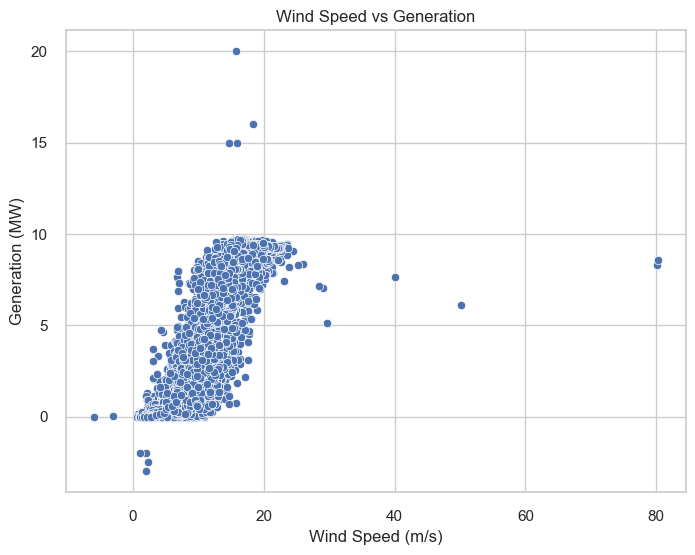

In [103]:
# Scatter plot: Wind Speed vs Generation
plt.figure(figsize=(8,6))
sns.scatterplot(x='WIND_SPEED_MS', y='GENERATION_MW', data=vf_perf_df)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Generation (MW)')
plt.title('Wind Speed vs Generation')
plt.show()


### Polynomial Regression (mimics the non‐linear “power curve”)

In [108]:
# Prepare polynomial features (degree=3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(vf_perf_df[['WIND_SPEED_MS']])

# Fit the model
poly_model = LinearRegression().fit(X_poly, vf_perf_df['GENERATION_MW'])


C:\Users\patri\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


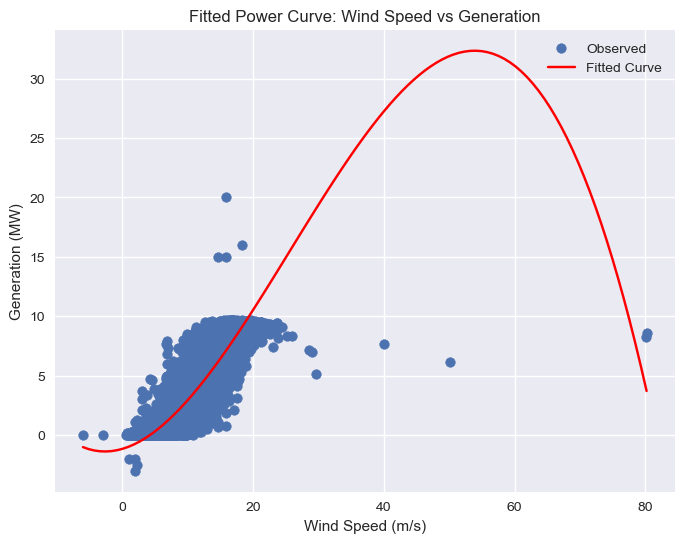

In [78]:
# Plot the fitted curve
x_range = np.linspace(vf_perf_df['WIND_SPEED_MS'].min(), vf_perf_df['WIND_SPEED_MS'].max(), 100)
x_range_poly = poly.transform(x_range.reshape(-1, 1))
y_pred = poly_model.predict(x_range_poly)

plt.figure(figsize=(8,6))
plt.scatter(vf_perf_df['WIND_SPEED_MS'], vf_perf_df['GENERATION_MW'], label='Observed')
plt.plot(x_range, y_pred, color='red', label='Fitted Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Generation (MW)')
plt.title('Fitted Power Curve: Wind Speed vs Generation')
plt.legend()
plt.show()

### Predict Future Generation

In [107]:
# Forecast generation for wind speeds 15 m/s and 35 m/s
wind_speeds = np.array([15, 35]).reshape(-1, 1)
wind_speeds_poly = poly.transform(wind_speeds)
forecast_generation = model.predict(wind_speeds_poly)
print("Forecast Generation for 15 m/s: {:.2f} MW".format(forecast_generation[0]))
print("Forecast Generation for 35 m/s: {:.2f} MW".format(forecast_generation[1]))


Forecast Generation for 15 m/s: 6.42 MW
Forecast Generation for 35 m/s: 23.56 MW


C:\Users\patri\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


### Calculate Forecast Accuracy Metrics

In [81]:
# Predict generation for the whole dataset
predicted_generation = poly_model.predict(X_poly)

# Calculate error metrics
mae = mean_absolute_error(vf_perf_df['GENERATION_MW'], predicted_generation)
rmse = np.sqrt(mean_squared_error(vf_perf_df['GENERATION_MW'], predicted_generation))
print("MAE: {:.2f} MW".format(mae))
print("RMSE: {:.2f} MW".format(rmse))


MAE: 0.95 MW
RMSE: 1.32 MW


### Evaluate Forecasting for Trading P&L Impact

In [86]:
# Add forecast error to the DataFrame
vf_perf_df['Forecast_Error'] = predicted_generation - vf_perf_df['GENERATION_MW']

# Calculate the P&L for each HH period
vf_perf_df['PnL'] = vf_perf_df['Forecast_Error'] * (
    vf_perf_df['FORWARD_PRICE_GBP_PER_MWH'] - vf_perf_df['CASHOUT_PRICE_GBP_PER_MWH'])

# Compute the total P&L impact over the period
total_pnl = vf_perf_df['PnL'].sum()
print("Total P&L impact: £{:.2f}".format(total_pnl))



Total P&L impact: £-146311.56


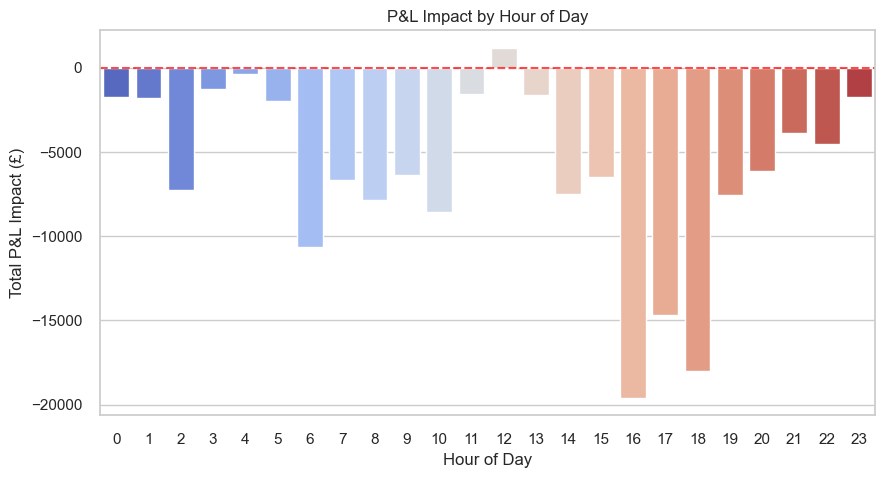

In [115]:
# Aggregate P&L impact by hour of the day
vf_perf_df['Hour'] = vf_perf_df.index.hour

pnl_by_hour = vf_perf_df.groupby('Hour')['PnL'].sum()

# Plot P&L impact by hour of the day
plt.figure(figsize=(10, 5))
sns.barplot(x=pnl_by_hour.index, y=pnl_by_hour.values, palette='coolwarm')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Hour of Day')
plt.ylabel('Total P&L Impact (£)')
plt.title('P&L Impact by Hour of Day')
plt.show()


### Correlation Analysis: Windspeed and Market Prices


In [92]:
# Correlation between wind speed and forward price
corr_forward = vf_perf_df['WIND_SPEED_MS'].corr(vf_perf_df['FORWARD_PRICE_GBP_PER_MWH'])
print("Correlation (Wind Speed vs Forward Price):", round(corr_forward,2))

# Correlation between wind speed and cashout price
corr_cashout = vf_perf_df['WIND_SPEED_MS'].corr(vf_perf_df['CASHOUT_PRICE_GBP_PER_MWH'])
print("Correlation (Wind Speed vs Cashout Price):", round(corr_cashout,2))


Correlation (Wind Speed vs Forward Price): -0.32
Correlation (Wind Speed vs Cashout Price): -0.24


### Fit a Regression Line

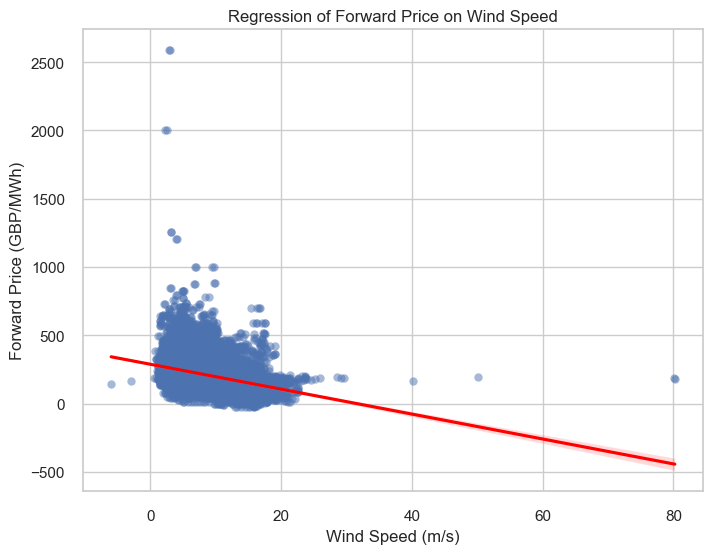

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style (optional)
sns.set(style="whitegrid")

# Create a regression plot of Forward Price vs Wind Speed
plt.figure(figsize=(8, 6))
sns.regplot(x='WIND_SPEED_MS', y='FORWARD_PRICE_GBP_PER_MWH', data=vf_perf_df, ci=95,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Regression of Forward Price on Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Forward Price (GBP/MWh)')
plt.show()


### Time Series: Granger Causality Test

In [106]:
# Conduct Granger Causality Test
# Set maximum lag (e.g., 4 lags corresponds to 2 hours of data for half-hourly observations)
maxlag = 4

print("Granger Causality Test: Does WIND_SPEED_MS help forecast FORWARD_PRICE_GBP_PER_MWH?")
# The test function expects a DataFrame where the first column is the target (forward price)
grangercausalitytests(vf_perf_df[['FORWARD_PRICE_GBP_PER_MWH', 'WIND_SPEED_MS']], maxlag=maxlag, verbose=True)

print("\nGranger Causality Test: Does GENERATION_MW help forecast FORWARD_PRICE_GBP_PER_MWH?")
grangercausalitytests(vf_perf_df[['FORWARD_PRICE_GBP_PER_MWH', 'GENERATION_MW']], maxlag=maxlag, verbose=True)


Granger Causality Test: Does WIND_SPEED_MS help forecast FORWARD_PRICE_GBP_PER_MWH?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.1173 , p=0.0000  , df_denom=17516, df_num=1
ssr based chi2 test:   chi2=33.1230 , p=0.0000  , df=1
likelihood ratio test: chi2=33.0917 , p=0.0000  , df=1
parameter F test:         F=33.1173 , p=0.0000  , df_denom=17516, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.2525 , p=0.0000  , df_denom=17513, df_num=2
ssr based chi2 test:   chi2=34.5148 , p=0.0000  , df=2
likelihood ratio test: chi2=34.4809 , p=0.0000  , df=2
parameter F test:         F=17.2525 , p=0.0000  , df_denom=17513, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22.1348 , p=0.0000  , df_denom=17510, df_num=3
ssr based chi2 test:   chi2=66.4308 , p=0.0000  , df=3
likelihood ratio test: chi2=66.3052 , p=0.0000  , df=3
parameter F test:         F=22.1348 , p=0.0000  , df_denom=17510, df_num=

{1: ({'ssr_ftest': (20.078001809364675, 7.481768981511403e-06, 17516.0, 1),
   'ssr_chi2test': (20.081440608487085, 7.421336899373737e-06, 1),
   'lrtest': (20.069940056069754, 7.466099305175434e-06, 1),
   'params_ftest': (20.078001809371802, 7.481768981487667e-06, 17516.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (10.59060822723989, 2.5312582722787356e-05, 17513.0, 2),
   'ssr_chi2test': (21.18726373834162, 2.5075184425935762e-05, 2),
   'lrtest': (21.174461519985925, 2.5236208234773053e-05, 2),
   'params_ftest': (10.59060822723885, 2.5312582722787356e-05, 17513.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (14.723393847936729, 1.4260592547514689e-09, 17510.0, 3),
   'ssr_chi2test': (44.18783952615208, 1.3766977004636127e-09, 3),
   'lrtest': (44.13219964178279, 1.414681452640366e-09, 3),
   'params_ftest': (14.723393847936848, 1.4260592547514689e-09, 17510.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0.